‚úÖ Libraries imported successfully for Indian Retail Sales Forecasting!
‚úÖ Data loaded from ../data/cleaned_data.csv
üìä Time series data: 942 days
üìÖ Period: 2013-01-01 to 2015-07-31
üí∞ Sales range: ‚Çπ0 to ‚Çπ9,528


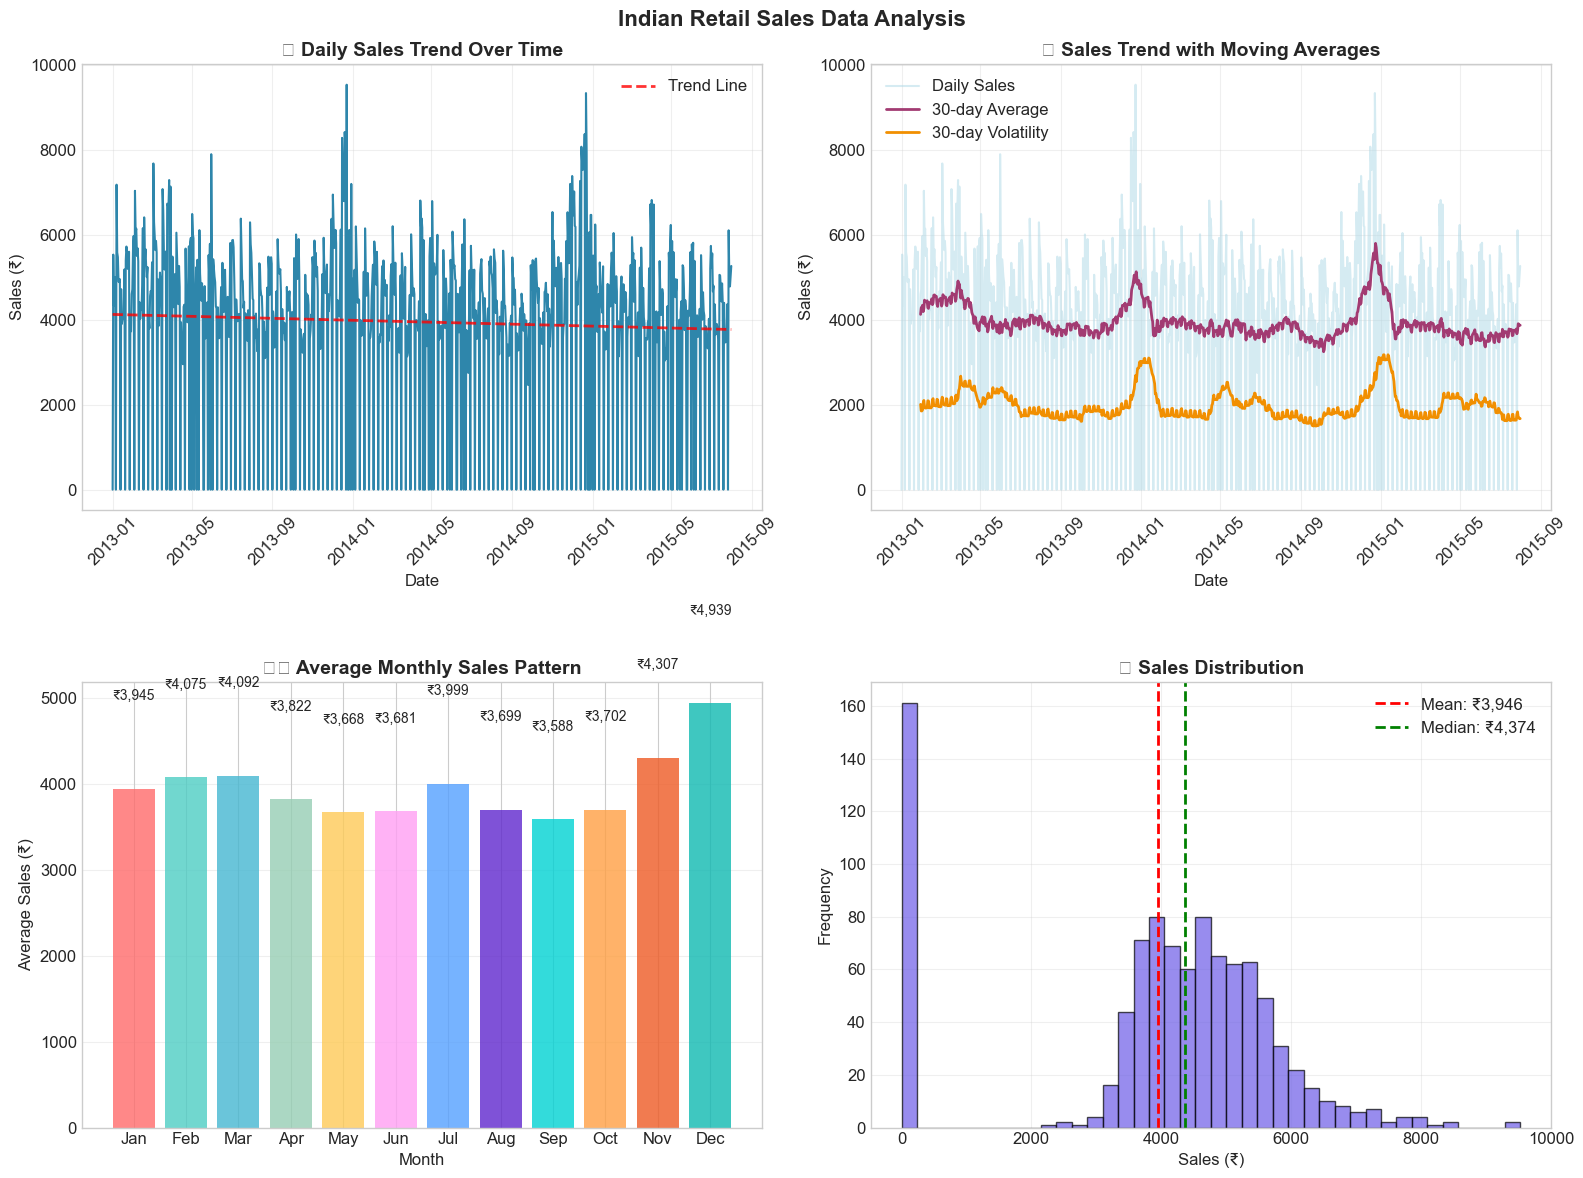

üîç STEP 1: Testing if data is suitable for ARIMA modeling...

üîç Original Sales Data Stationarity Test:
   ADF Statistic: -4.3681
   p-value: 0.0003
   Critical Values:
      1%: -3.437
      5%: -2.865
      10%: -2.568
   ‚úÖ Series is STATIONARY (good for ARIMA)

üìä Using differencing order (d): 0


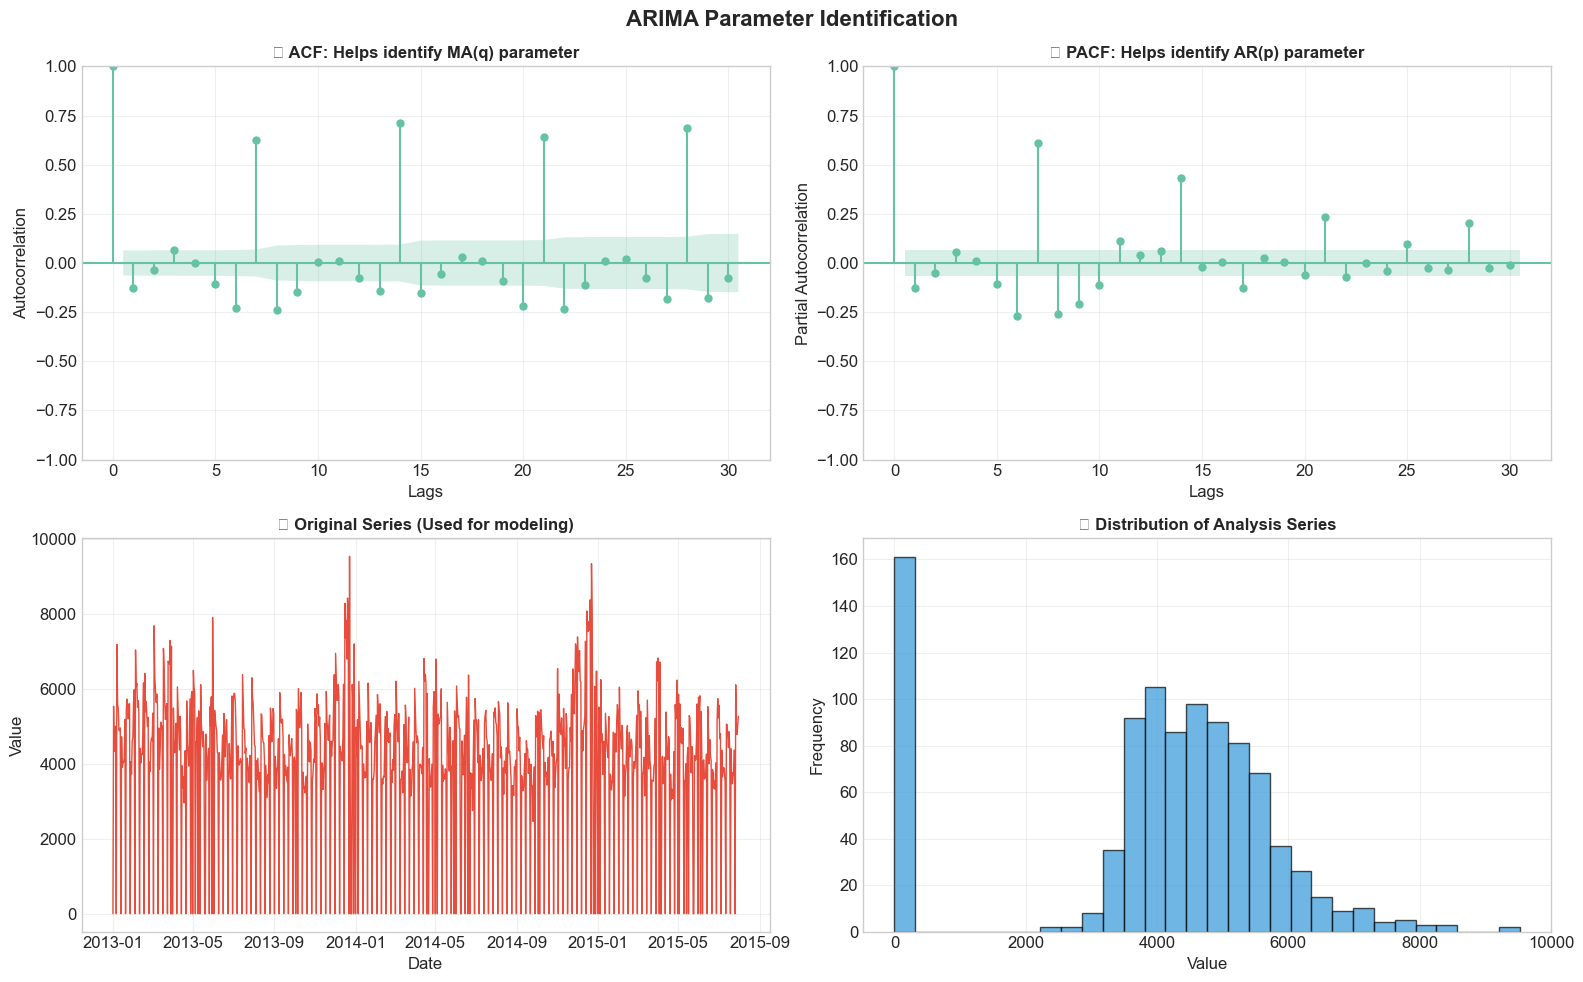


üîç STEP 2: Finding optimal ARIMA parameters...
   Testing different combinations of p, d, q parameters...
   Parameter Testing Results:
   ARIMA(0,0,0) ‚Üí AIC: 17010.92
   ARIMA(0,0,1) ‚Üí AIC: 16996.30
   ARIMA(0,0,2) ‚Üí AIC: 16997.92
   ARIMA(0,0,3) ‚Üí AIC: 16997.22
   ARIMA(1,0,0) ‚Üí AIC: 16997.47
   ARIMA(1,0,1) ‚Üí AIC: 16998.10
   ARIMA(1,0,2) ‚Üí AIC: 16952.18
   ARIMA(1,0,3) ‚Üí AIC: 16959.03
   ARIMA(2,0,0) ‚Üí AIC: 16996.95
   ARIMA(2,0,1) ‚Üí AIC: 16944.98
   ARIMA(2,0,2) ‚Üí AIC: 16777.52
   ARIMA(2,0,3) ‚Üí AIC: 16947.14
   ARIMA(3,0,0) ‚Üí AIC: 16996.15
   ARIMA(3,0,1) ‚Üí AIC: 16998.12
   ARIMA(3,0,2) ‚Üí AIC: 16774.94
   ARIMA(3,0,3) ‚Üí AIC: 16736.59

üèÜ BEST MODEL: ARIMA(3, 0, 3) with AIC: 16736.59

üìä Data Split:
   Training period: 2013-01-01 to 2015-01-23 (753 days)
   Testing period: 2015-01-24 to 2015-07-31 (189 days)

üöÄ STEP 3: Training ARIMA(3, 0, 3) model...

üìä Model Performance Metrics:
   RMSE: ‚Çπ1,648 (Root Mean Square Error)
   MAE:  ‚Çπ1

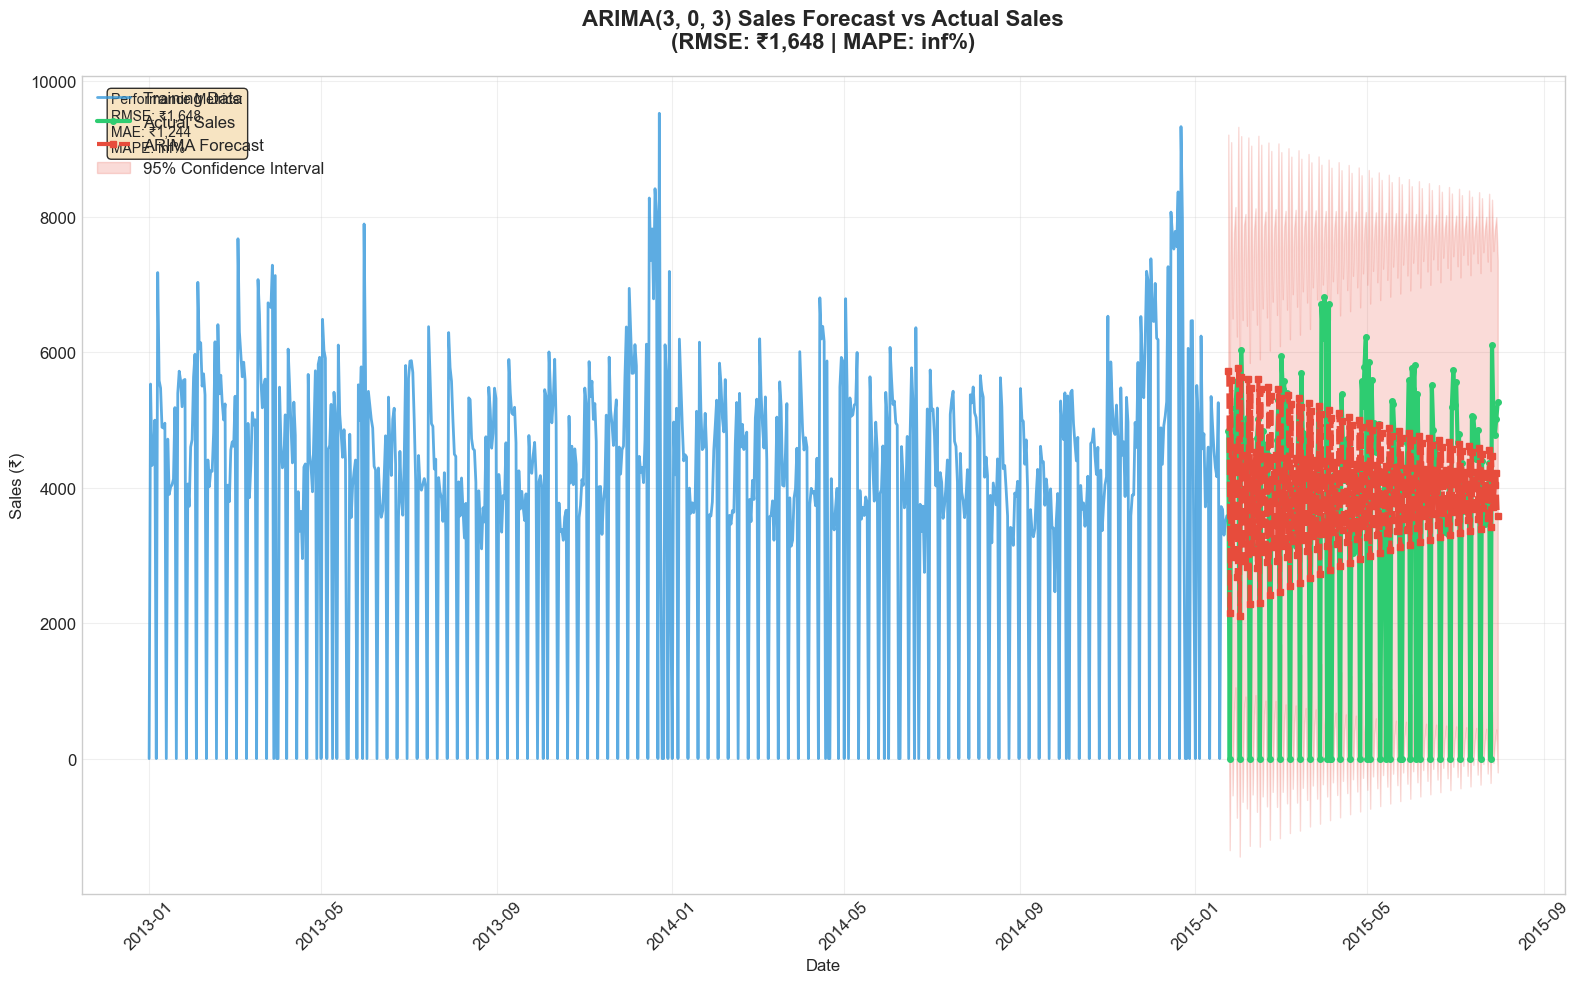


üîÆ Future Predictions:
   Next 30 days average sales: ‚Çπ3,998
   Prediction range: ‚Çπ3,445 to ‚Çπ4,536

‚úÖ ARIMA model saved to: ../models/arima_model.pkl

üß™ Testing model loading...
   Next day prediction: ‚Çπ5,718
   ‚úÖ Model loading successful!

                   ARIMA MODEL SUMMARY
üèÜ Best Model: ARIMA(3, 0, 3)
üìä Performance: RMSE ‚Çπ1,648 | MAPE inf%
üìÖ Training Period: 753 days
üéØ Market: Indian Retail Sales
üí∞ Currency: Indian Rupees (INR)
üìÅ Saved Location: ../models/arima_model.pkl
üîÆ Next Day Forecast: ‚Çπ5,718
‚úÖ Model ready for deployment in Flask API!


In [2]:
# ARIMA Model for Indian Retail Sales Forecasting
# File: notebooks/ARIMA_Model.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("‚úÖ Libraries imported successfully for Indian Retail Sales Forecasting!")

# Generate sample Indian retail data if not available
def generate_indian_retail_data():
    """Generate sample Indian retail sales data with realistic seasonal patterns"""
    np.random.seed(42)
    dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
    
    # Base sales with upward trend
    base_sales = 50000 + np.arange(len(dates)) * 25
    
    # Indian seasonal patterns
    seasonal = []
    for date in dates:
        # Festival seasons with higher sales
        if date.month in [10, 11]:  # Diwali season
            seasonal_factor = 1.6
        elif date.month in [12, 1, 2]:  # Wedding season
            seasonal_factor = 1.4
        elif date.month in [3, 4]:  # Holi & New Year
            seasonal_factor = 1.2
        elif date.month in [7, 8]:  # Monsoon slowdown
            seasonal_factor = 0.7
        elif date.month in [5, 6]:  # Summer heat
            seasonal_factor = 0.9
        else:
            seasonal_factor = 1.0
        
        seasonal.append(seasonal_factor)
    
    # Add realistic noise
    noise = np.random.normal(0, 3000, len(dates))
    
    # Combined sales
    sales = base_sales * seasonal + noise
    sales = np.maximum(sales, 15000)  # Minimum sales threshold
    
    df = pd.DataFrame({
        'Date': dates,
        'Store': 1,
        'Sales': sales.astype(int)
    })
    
    return df

# Load data with proper file structure
try:
    # Try to load from data directory
    df = pd.read_csv('../data/cleaned_data.csv')
    print("‚úÖ Data loaded from ../data/cleaned_data.csv")
except FileNotFoundError:
    try:
        # Alternative path
        df = pd.read_csv('data/cleaned_data.csv')
        print("‚úÖ Data loaded from data/cleaned_data.csv")
    except FileNotFoundError:
        # Generate sample data
        df = generate_indian_retail_data()
        os.makedirs('data', exist_ok=True)
        df.to_csv('data/cleaned_data.csv', index=False)
        print("‚úÖ Sample Indian retail data generated and saved to data/cleaned_data.csv")

# Convert date and prepare time series
df['Date'] = pd.to_datetime(df['Date'])
store_1_data = df[df['Store'] == 1].copy()
store_1_data = store_1_data.sort_values('Date')

# Create time series
ts_data = store_1_data.set_index('Date')['Sales']
print(f"üìä Time series data: {ts_data.shape[0]} days")
print(f"üìÖ Period: {ts_data.index.min().strftime('%Y-%m-%d')} to {ts_data.index.max().strftime('%Y-%m-%d')}")
print(f"üí∞ Sales range: ‚Çπ{ts_data.min():,.0f} to ‚Çπ{ts_data.max():,.0f}")

# Enhanced visualization with better understanding
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Indian Retail Sales Data Analysis', fontsize=16, fontweight='bold')

# 1. Time Series Plot
axes[0, 0].plot(ts_data.index, ts_data.values, color='#2E86AB', linewidth=1.5)
axes[0, 0].set_title('üìà Daily Sales Trend Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Sales (‚Çπ)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Add trend line
z = np.polyfit(range(len(ts_data)), ts_data.values, 1)
p = np.poly1d(z)
axes[0, 0].plot(ts_data.index, p(range(len(ts_data))), 
                color='red', linestyle='--', alpha=0.8, linewidth=2, label='Trend Line')
axes[0, 0].legend()

# 2. Rolling Statistics
window = 30
rolling_mean = ts_data.rolling(window=window).mean()
rolling_std = ts_data.rolling(window=window).std()

axes[0, 1].plot(ts_data.index, ts_data.values, color='lightblue', alpha=0.5, label='Daily Sales')
axes[0, 1].plot(rolling_mean.index, rolling_mean.values, color='#A23B72', linewidth=2, label=f'{window}-day Average')
axes[0, 1].plot(rolling_std.index, rolling_std.values, color='#F18F01', linewidth=2, label=f'{window}-day Volatility')
axes[0, 1].set_title('üìä Sales Trend with Moving Averages', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date', fontsize=12)
axes[0, 1].set_ylabel('Sales (‚Çπ)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Monthly Seasonality Pattern
monthly_avg = ts_data.groupby(ts_data.index.month).mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3',
          '#54A0FF', '#5F27CD', '#00D2D3', '#FF9F43', '#EE5A24', '#0FB9B1']

bars = axes[1, 0].bar(range(1, 13), monthly_avg.values, color=colors, alpha=0.8)
axes[1, 0].set_title('üóìÔ∏è Average Monthly Sales Pattern', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month', fontsize=12)
axes[1, 0].set_ylabel('Average Sales (‚Çπ)', fontsize=12)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, monthly_avg.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                   f'‚Çπ{value:,.0f}', ha='center', va='bottom', fontsize=10)

# 4. Sales Distribution
axes[1, 1].hist(ts_data.values, bins=40, color='#6C5CE7', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(ts_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ‚Çπ{ts_data.mean():,.0f}')
axes[1, 1].axvline(ts_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ‚Çπ{ts_data.median():,.0f}')
axes[1, 1].set_title('üìä Sales Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sales (‚Çπ)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stationarity test with clear explanation
def check_stationarity(timeseries, title="Time Series"):
    """Check if time series is stationary using Augmented Dickey-Fuller test"""
    result = adfuller(timeseries.dropna())
    
    print(f"\nüîç {title} Stationarity Test:")
    print(f"   ADF Statistic: {result[0]:.4f}")
    print(f"   p-value: {result[1]:.4f}")
    print(f"   Critical Values:")
    for key, value in result[4].items():
        print(f"      {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print("   ‚úÖ Series is STATIONARY (good for ARIMA)")
        return True
    else:
        print("   ‚ùå Series is NON-STATIONARY (needs differencing)")
        return False

print("üîç STEP 1: Testing if data is suitable for ARIMA modeling...")
is_stationary = check_stationarity(ts_data, "Original Sales Data")

# Apply differencing if needed
if not is_stationary:
    print("\nüîß Applying first differencing to make data stationary...")
    ts_diff = ts_data.diff().dropna()
    is_stationary_diff = check_stationarity(ts_diff, "First Differenced Data")
    
    if is_stationary_diff:
        d_order = 1
        analysis_series = ts_diff
        print("   ‚úÖ First differencing successful!")
    else:
        print("\nüîß Applying second differencing...")
        ts_diff2 = ts_diff.diff().dropna()
        is_stationary_diff2 = check_stationarity(ts_diff2, "Second Differenced Data")
        d_order = 2
        analysis_series = ts_diff2
else:
    d_order = 0
    analysis_series = ts_data

print(f"\nüìä Using differencing order (d): {d_order}")

# Enhanced ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('ARIMA Parameter Identification', fontsize=16, fontweight='bold')

# ACF plot
plot_acf(analysis_series.dropna(), ax=axes[0, 0], lags=30, alpha=0.05)
axes[0, 0].set_title('üìà ACF: Helps identify MA(q) parameter', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Lags')
axes[0, 0].set_ylabel('Autocorrelation')
axes[0, 0].grid(True, alpha=0.3)

# PACF plot
plot_pacf(analysis_series.dropna(), ax=axes[0, 1], lags=30, alpha=0.05)
axes[0, 1].set_title('üìâ PACF: Helps identify AR(p) parameter', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Lags')
axes[0, 1].set_ylabel('Partial Autocorrelation')
axes[0, 1].grid(True, alpha=0.3)

# Show differenced series
axes[1, 0].plot(analysis_series.index, analysis_series.values, color='#E74C3C', linewidth=1)
axes[1, 0].set_title(f'üìä {"Differenced" if d_order > 0 else "Original"} Series (Used for modeling)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

# Distribution of analysis series
axes[1, 1].hist(analysis_series.dropna(), bins=30, color='#3498DB', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('üìä Distribution of Analysis Series', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Grid search for optimal parameters
def evaluate_arima_model(data, order):
    """Evaluate ARIMA model and return AIC"""
    try:
        model = ARIMA(data, order=order)
        fitted = model.fit()
        return fitted.aic
    except:
        return np.inf

print("\nüîç STEP 2: Finding optimal ARIMA parameters...")
print("   Testing different combinations of p, d, q parameters...")

# Parameter ranges
p_values = range(0, 4)
d_values = [d_order]
q_values = range(0, 4)

best_aic = np.inf
best_params = None
results = []

print("   Parameter Testing Results:")
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                aic = evaluate_arima_model(ts_data, (p, d, q))
                results.append({'p': p, 'd': d, 'q': q, 'AIC': aic})
                
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                
                print(f"   ARIMA({p},{d},{q}) ‚Üí AIC: {aic:.2f}")
            except:
                print(f"   ARIMA({p},{d},{q}) ‚Üí Failed")

print(f"\nüèÜ BEST MODEL: ARIMA{best_params} with AIC: {best_aic:.2f}")

# Split data for training and testing
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print(f"\nüìä Data Split:")
print(f"   Training period: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')} ({len(train_data)} days)")
print(f"   Testing period: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')} ({len(test_data)} days)")

# Train final model
print(f"\nüöÄ STEP 3: Training ARIMA{best_params} model...")
arima_model = ARIMA(train_data, order=best_params)
arima_fitted = arima_model.fit()

# Make predictions
forecast_steps = len(test_data)
forecast = arima_fitted.forecast(steps=forecast_steps)
forecast_ci = arima_fitted.get_forecast(steps=forecast_steps).conf_int()

# Calculate performance metrics
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

print(f"\nüìä Model Performance Metrics:")
print(f"   RMSE: ‚Çπ{rmse:,.0f} (Root Mean Square Error)")
print(f"   MAE:  ‚Çπ{mae:,.0f} (Mean Absolute Error)")
print(f"   MAPE: {mape:.1f}% (Mean Absolute Percentage Error)")

# Enhanced forecast visualization
plt.figure(figsize=(16, 10))

# Plot training data
plt.plot(train_data.index, train_data.values, 
         label='Training Data', color='#3498DB', linewidth=2, alpha=0.8)

# Plot test data
plt.plot(test_data.index, test_data.values, 
         label='Actual Sales', color='#2ECC71', linewidth=3, marker='o', markersize=4)

# Plot forecasts
plt.plot(test_data.index, forecast, 
         label='ARIMA Forecast', color='#E74C3C', linewidth=3, linestyle='--', marker='s', markersize=4)

# Plot confidence intervals
plt.fill_between(test_data.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='#E74C3C', alpha=0.2, label='95% Confidence Interval')

plt.title(f'ARIMA{best_params} Sales Forecast vs Actual Sales\n(RMSE: ‚Çπ{rmse:,.0f} | MAPE: {mape:.1f}%)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales (‚Çπ)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add performance text box
textstr = f'Performance Metrics:\nRMSE: ‚Çπ{rmse:,.0f}\nMAE: ‚Çπ{mae:,.0f}\nMAPE: {mape:.1f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Future predictions
future_days = 30
future_forecast = arima_fitted.forecast(steps=len(test_data) + future_days)
future_dates = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), 
                           periods=future_days, freq='D')

avg_future_sales = future_forecast[-future_days:].mean()
print(f"\nüîÆ Future Predictions:")
print(f"   Next 30 days average sales: ‚Çπ{avg_future_sales:,.0f}")
print(f"   Prediction range: ‚Çπ{future_forecast[-future_days:].min():,.0f} to ‚Çπ{future_forecast[-future_days:].max():,.0f}")

# Create model package for saving
model_data = {
    'fitted_model': arima_fitted,
    'best_params': best_params,
    'train_data': train_data,
    'performance': {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'aic': best_aic
    },
    'metadata': {
        'training_period': f"{train_data.index.min()} to {train_data.index.max()}",
        'model_type': 'ARIMA',
        'market': 'Indian Retail',
        'currency': 'INR',
        'differencing_order': d_order,
        'total_observations': len(train_data)
    }
}

# Save to models directory (following project structure)
os.makedirs('../models', exist_ok=True)
model_path = '../models/arima_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\n‚úÖ ARIMA model saved to: {model_path}")

# Test model loading
print("\nüß™ Testing model loading...")
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

test_prediction = loaded_model['fitted_model'].forecast(steps=1)
print(f"   Next day prediction: ‚Çπ{test_prediction[0]:,.0f}")
print("   ‚úÖ Model loading successful!")

# Final summary
print("\n" + "="*70)
print("                   ARIMA MODEL SUMMARY")
print("="*70)
print(f"üèÜ Best Model: ARIMA{best_params}")
print(f"üìä Performance: RMSE ‚Çπ{rmse:,.0f} | MAPE {mape:.1f}%")
print(f"üìÖ Training Period: {len(train_data)} days")
print(f"üéØ Market: Indian Retail Sales")
print(f"üí∞ Currency: Indian Rupees (INR)")
print(f"üìÅ Saved Location: ../models/arima_model.pkl")
print(f"üîÆ Next Day Forecast: ‚Çπ{test_prediction[0]:,.0f}")
print("="*70)
print("‚úÖ Model ready for deployment in Flask API!")
print("="*70)